# Modelling

- Let's attempt to build a frequency vs severity model using both GLM and GBM. Remember that technically `premium = frequency * severity`
- Bonus: see if along the way we can use the variable importance to identify key rating factors for both frequency and severity that can be used for risk classification

## 001: Create the dataset and split dataset

In [1]:
from src.dataset import Dataset


insurance_initiation_variables_path = "../data/input/exp/Insurance_Initiation_Variables.csv"
claims_variables_path = "../data/input/exp/sample_type_claim.csv"

claim_grouping_columns = ['ID', 'Cost_claims_year']
claim_aggregation_column = 'Cost_claims_by_type'
merging_columns = ['ID', 'Cost_claims_year']

dataset =  (Dataset(data_path=insurance_initiation_variables_path,
                              claims_path=claims_variables_path)
                      .group_claims(grouping_columns=claim_grouping_columns,aggregation_column=claim_aggregation_column)
                      .create_dataset(merge_columns=merging_columns)
                     )
trainset, testset = dataset.split_dataset(test_ratio=0.2, to_shuffle=False)

## 002: Engineer relevant features

In [2]:
from src.feature import  main as feature_main

features_trainset = feature_main(trainset)
features_testset = feature_main(testset)

## 003: Frequency modelling - Poisson regression

The response variable is the number of claims dubbed `claims_frequency` in the dataset. It is important to note that Claims frequency is actually a rate (i.e. it is the claims frequency for a year for each policy-holder). However, since the exposure is constant for all policies in this dataset (1 year), it is an implicit rate.


Let's check a few assumptions before we fit a Poisson regression model:
1. Distribution of the response variable
2. Equidispersion: the mean and variance of the response variable should be roughly equal

Average claims frequency: 0.06818720098526834
Fraction of claims frequency that is Zero 95.13%


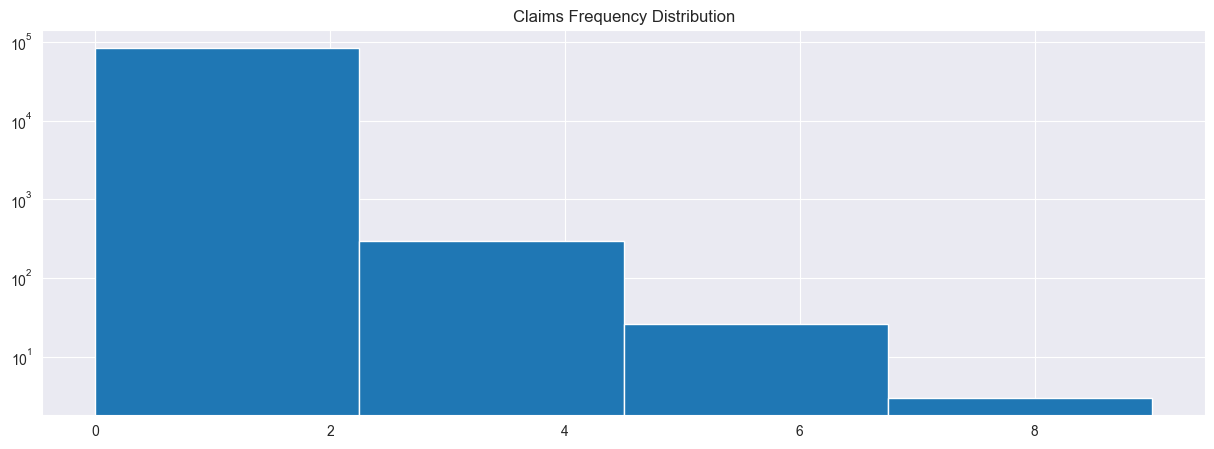

In [6]:
import numpy as np
import matplotlib.pyplot as plt
fig, (ax0) = plt.subplots(ncols=1, figsize=(15, 5))
ax0.set_title('Claims Frequency Distribution')
_ = features_trainset['claims_frequency'].hist(bins=4, log=True, ax=ax0)

print(
    "Average claims frequency: {}".format(
        np.average(features_trainset['claims_frequency'])
    )
)

print(
    "Fraction of claims frequency that is Zero {0:.2%}".format(
        features_trainset[features_trainset['claims_frequency']==0].__len__() / features_trainset['claims_frequency'].__len__()
    )
)

In [7]:
mean_claims_frequency = features_trainset['claims_frequency'].mean()
var_claims_frequency = features_trainset['claims_frequency'].var()
print(f"Mean of claims_frequency: {mean_claims_frequency :.4f}")
print(f"Variance of claims_frequency: {var_claims_frequency:.4f}")

Mean of claims_frequency: 0.0682
Variance of claims_frequency: 0.1184


- From the both the histogram and the mean-variance comparison, we can see that the claims frequency is unimodal and rightly skewed, the mean and variance after filling nulls with 0 appear to be reasonably close for this dataset. We can therefore proceed to fit a Poisson regression model.

In [8]:
training_variables = ['Car_age_years', 'Type_risk', 'Area', 'Value_vehicle', 'Distribution_channel', 'Cylinder_capacity']
target = ['claims_frequency']

In [9]:
from sklearn.metrics import mean_absolute_error,mean_poisson_deviance,mean_squared_error

def model_evaluation_metrics(estimator, df_test, target_variable=target, training_variables=training_variables):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test[training_variables])

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test[target], y_pred,
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test[target], y_pred
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            df_test[target][mask],
            y_pred[mask],
        )
    )


#### Model 1 - Baseline Model, Just predicting the mean

In [10]:
from sklearn.dummy import DummyRegressor
dummy_regressor = DummyRegressor(strategy="mean")
baseline_model = dummy_regressor.fit(features_trainset[training_variables], features_trainset[target])
print("Constant mean frequency evaluation:")
model_evaluation_metrics(estimator=baseline_model, df_test=features_testset, target_variable=target, training_variables=training_variables)

Constant mean frequency evaluation:
MSE: 0.132
MAE: 0.137
mean Poisson deviance: 0.463


#### Model 2 - Ridge Regression

In [11]:
from sklearn.linear_model import Ridge
ridge_glm = Ridge(alpha=1)
ridge_model = ridge_glm.fit(features_trainset[training_variables], features_trainset[target])
print("Ridge regression evaluation:")
model_evaluation_metrics(estimator=ridge_model, df_test=features_testset, target_variable=target, training_variables=training_variables)

Ridge regression evaluation:
MSE: 0.131
MAE: 0.137
mean Poisson deviance: 0.460


#### Model 3 - Poisson Regression

In [12]:
from sklearn.linear_model import PoissonRegressor
poisson_regressor = PoissonRegressor(alpha=1e-12, solver='newton-cholesky', max_iter=300)
poisson_model = poisson_regressor.fit(features_trainset[training_variables], features_trainset[target].values.ravel())
print("Poisson regression evaluation:")
model_evaluation_metrics(estimator=poisson_model, df_test=features_testset, target_variable=target, training_variables=training_variables)

Poisson regression evaluation:
MSE: 0.131
MAE: 0.137
mean Poisson deviance: 0.460


#### Model 4 - Gradient Boosting Machine


In [13]:
from sklearn.ensemble import HistGradientBoostingRegressor
gbm_regressor = HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128)
gbm_model = gbm_regressor.fit(features_trainset[training_variables], features_trainset['claims_frequency'])
print("GBM regression evaluation:")
model_evaluation_metrics(estimator=gbm_model, df_test=features_testset, target_variable=target, training_variables=training_variables)

GBM regression evaluation:
MSE: 0.132
MAE: 0.140
mean Poisson deviance: 0.462


## 004: Frequency Modelling Evaluation

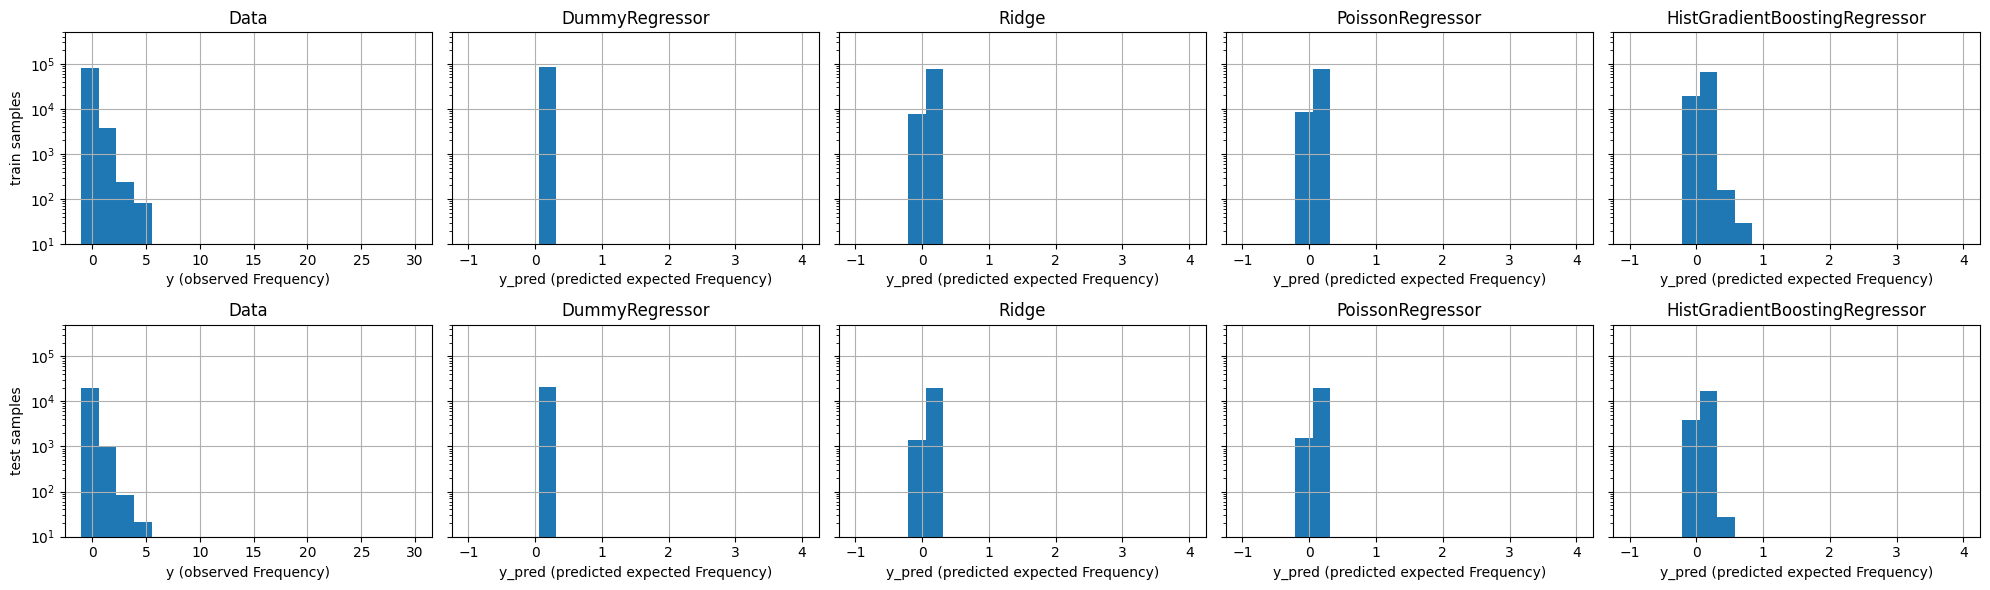

In [23]:
import pandas as pd
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [features_trainset, features_testset]):
    df["claims_frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([baseline_model, ridge_glm, poisson_regressor, gbm_regressor ]):
        y_pred = model.predict(df[training_variables])

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set_title(model.__class__.__name__)
        axes[row_idx, idx + 1].set_yscale("log")
        axes[row_idx, idx + 1].set_xlabel("y_pred (predicted expected Frequency)")
plt.tight_layout()

Actual number of claims: 1611.0
Predicted number of claims by DummyRegressor: 1439.5
Predicted number of claims by Ridge: 1450.6
Predicted number of claims by PoissonRegressor: 1446.4
Predicted number of claims by HistGradientBoostingRegressor: 1515.0


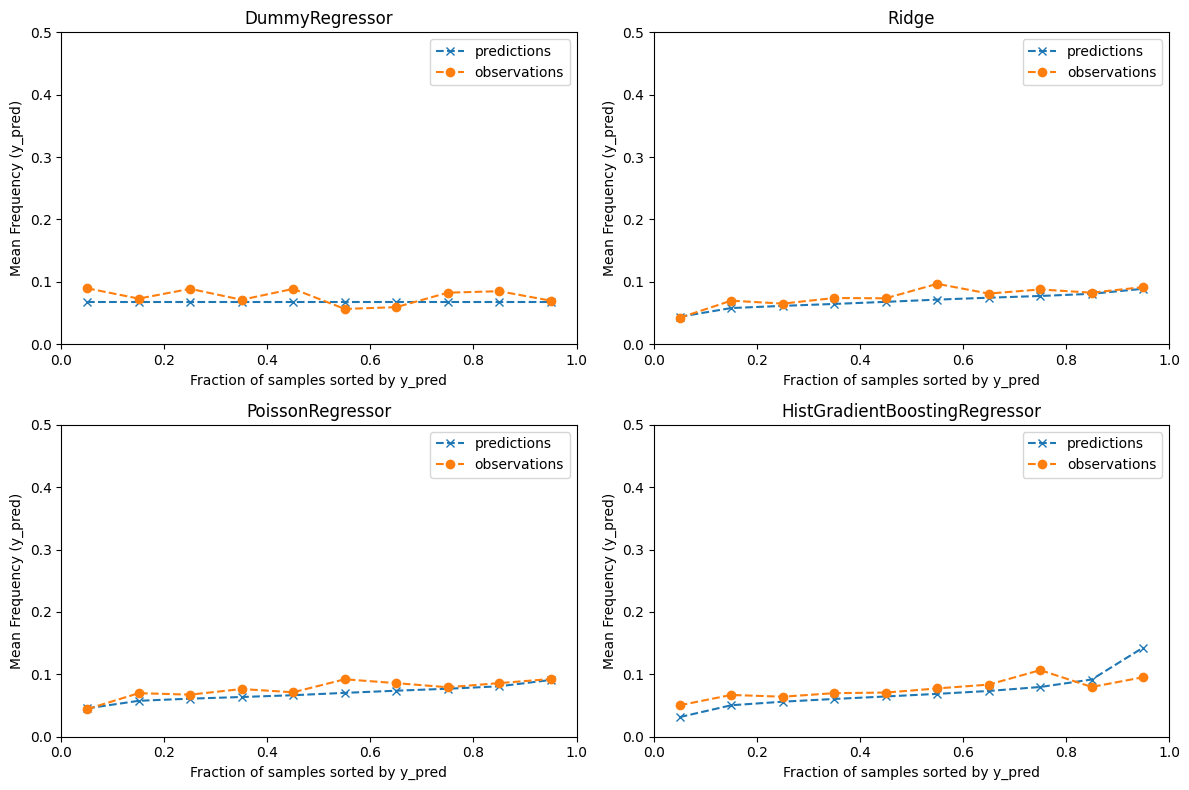

In [26]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, n_bins=100):
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], )
        y_true_bin[n] = np.average(y_true[idx_sort][sl], )
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {features_testset['claims_frequency'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [baseline_model, ridge_glm, poisson_regressor, gbm_regressor]):
    y_pred = model.predict(features_testset[training_variables])
    y_true = features_testset['claims_frequency'].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, n_bins=10
    )

    print(f"Predicted number of claims by {model.__class__.__name__}: {np.sum(y_pred):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set_title(model.__class__.__name__)
    axi.set_xlabel("Fraction of samples sorted by y_pred")
    axi.set_ylabel("Mean Frequency (y_pred)")
    axi.legend()
plt.tight_layout()